# Predictive Analysis of COVID-19

In [1]:
# PG-32 (Team Analyzers)

# Hemant Sathish - PES2201800045
# Dhanik Shetty - PES2201800704
# Chinmaya Ravi - PES2201800083
# Ashwathnarayan M - PES2201800341

####  COVID-19 has been recognized as a global threat, and several studies are being conducted using various mathematical models to predict the probable evolution of this epidemic. These mathematical models are based on various factors and analysis are subject to potential bias.
####  Data analytics plays an important role in analyzing and predicting the spread of the virus, which will help in stabilizing the situation in the fastest possible way.

### Importing Necessary Packages

In [2]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
pio.renderers
from pandas_datareader import data as web 

from datetime import datetime as dt
from datetime import timedelta

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima, ADFTest

In [3]:
#Loading the dataset

#covid = pd.read_csv("C:/Users/sathi.LAPTOP-6VSGULQ7/Desktop/DA_Project/covid_19_data_latest.csv")
covid = pd.read_csv("covid_19_data_latest.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156292 entries, 0 to 156291
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              156292 non-null  int64  
 1   ObservationDate  156292 non-null  object 
 2   Province/State   111979 non-null  object 
 3   Country/Region   156292 non-null  object 
 4   Last Update      156292 non-null  object 
 5   Confirmed        156292 non-null  float64
 6   Deaths           156292 non-null  float64
 7   Recovered        156292 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 9.5+ MB


In [5]:
covid.describe()

,SNo,Confirmed,Deaths,Recovered
count,156292.000000,1.562920e+05,156292.000000,1.562920e+05
mean,78146.500000,2.844340e+04,966.090273,1.793232e+04
std,45117.758473,8.809800e+04,3278.110680,9.813018e+04
min,1.000000,-3.028440e+05,-178.000000,-8.544050e+05
25%,39073.750000,3.900000e+02,5.000000,1.000000e+01
50%,78146.500000,3.410000e+03,67.000000,7.570000e+02
75%,117219.250000,1.597875e+04,486.000000,6.270000e+03
max,156292.000000,1.867721e+06,45974.000000,4.174884e+06


### Preprocessing 

In [6]:
#modifying the dataframe

covid = covid.drop(['SNo','Last Update'],axis=1)
covid = covid.rename(columns={'ObservationDate':'Date','Province/State':'State','Country/Region':'Country'})
covid.head()

,Date,State,Country,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0


In [7]:
#total number of confirmed cases, recovered cases and deaths until 15th November 2020

confirmed=covid.loc[covid['Date'] == '11/15/2020']
confirmed = confirmed.groupby(['Country']).sum()[['Confirmed','Recovered','Deaths']].sort_values(by=['Confirmed'], ascending=False)
confirmed.head()

,Confirmed,Recovered,Deaths
Country,,,
US,11036935.0,4174884.0,246214.0
India,8845127.0,8249579.0,130070.0
Brazil,5863093.0,5279452.0,165798.0
France,1915713.0,139760.0,42601.0
Russia,1910149.0,1429565.0,32885.0


In [8]:
covid.Date = pd.to_datetime(covid.Date.astype(str), dayfirst=False, errors='coerce')
covid.Date.tail()

156287   2020-11-15
156288   2020-11-15
156289   2020-11-15
156290   2020-11-15
156291   2020-11-15
Name: Date, dtype: datetime64[ns]

In [9]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156292 entries, 0 to 156291
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       156292 non-null  datetime64[ns]
 1   State      111979 non-null  object        
 2   Country    156292 non-null  object        
 3   Confirmed  156292 non-null  float64       
 4   Deaths     156292 non-null  float64       
 5   Recovered  156292 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 7.2+ MB


### EDA and Visualization

In [10]:
#Getting the cumulative sum of all the cases reported in a day

cumulative_confirmed = covid.groupby('Date').Confirmed.sum()
cumulative_confirmed = cumulative_confirmed.groupby(cumulative_confirmed.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_confirmed['Confirmed'].iloc[i] = cumulative_confirmed['Confirmed'].iloc[i]-cumulative_confirmed['Confirmed'].iloc[i-1]
cumulative_confirmed.head()

,Date,Confirmed
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0


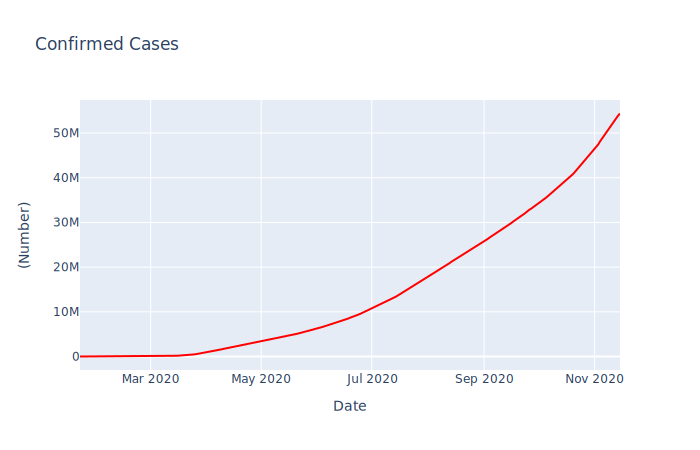

In [11]:
#Plotting a graph for the cumulative confirmed cases

confirmed_graph = go.Scatter(x=cumulative_confirmed.Date,y=cumulative_confirmed.Confirmed, marker=dict(color='red'))
layout = go.Layout(title='Confirmed Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[confirmed_graph], layout=layout)
fig.update_layout()
fig.show("svg")

In [12]:
#Getting the cumulative sum of all the recovered cases reported in a day

cumulative_recovered = covid.groupby('Date').Recovered.sum()
cumulative_recovered = cumulative_recovered.groupby(cumulative_recovered.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_recovered['Recovered'].iloc[i] = cumulative_recovered['Recovered'].iloc[i]-cumulative_recovered['Recovered'].iloc[i-1]
cumulative_recovered.tail(10)

,Date,Recovered
289,2020-11-06,32480626.0
290,2020-11-07,32779541.0
291,2020-11-08,33032762.0
292,2020-11-09,33289404.0
293,2020-11-10,33544236.0
294,2020-11-11,33926351.0
295,2020-11-12,34149223.0
296,2020-11-13,34450332.0
297,2020-11-14,34726418.0
298,2020-11-15,34955148.0


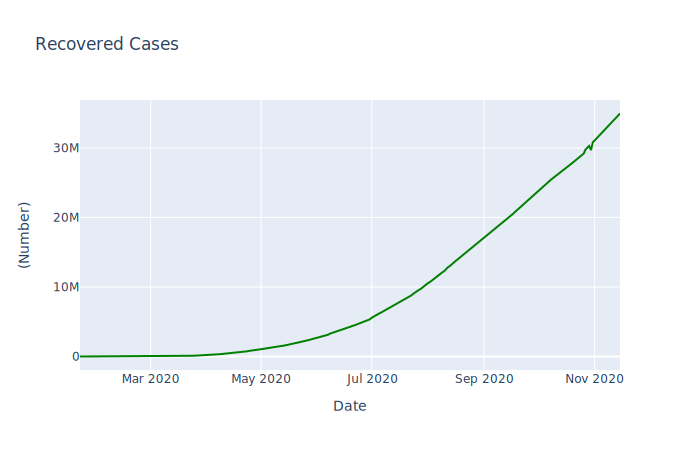

In [13]:
#Plotting a graph for the cumulative recovered cases

recovered_graph = go.Scatter(x=cumulative_recovered.Date,y=cumulative_recovered.Recovered, marker=dict(color='green'))
layout = go.Layout(title='Recovered Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[recovered_graph], layout=layout)
fig.update_layout()
fig.show(renderer="svg")

In [14]:
#Getting the cumulative sum of all the deaths reported in a day

cumulative_deaths = covid.groupby('Date').Deaths.sum()
cumulative_deaths = cumulative_deaths.groupby(cumulative_deaths.index.to_period('y')).cumsum().reset_index()
for i in range(298,0,-1):
    cumulative_deaths['Deaths'].iloc[i] = cumulative_deaths['Deaths'].iloc[i]-cumulative_deaths['Deaths'].iloc[i-1]
cumulative_deaths.head(10)

,Date,Deaths
0,2020-01-22,17.0
1,2020-01-23,18.0
2,2020-01-24,26.0
3,2020-01-25,42.0
4,2020-01-26,56.0
5,2020-01-27,82.0
6,2020-01-28,131.0
7,2020-01-29,133.0
8,2020-01-30,171.0
9,2020-01-31,213.0


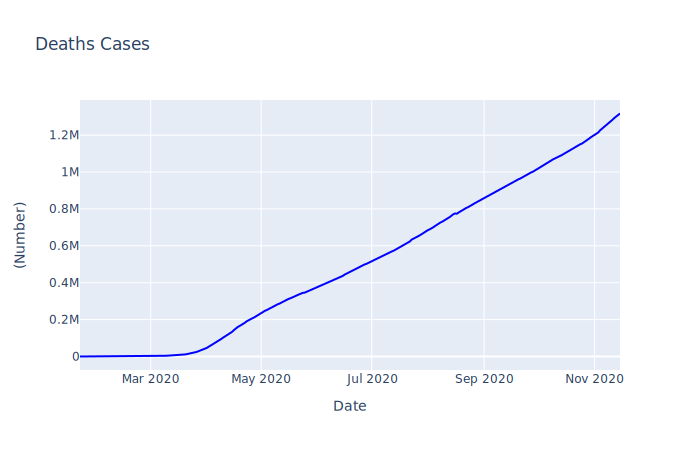

In [15]:
#Plotting a graph for the cumulative sum of deaths

death_graph = go.Scatter(x=cumulative_deaths.Date,y=cumulative_deaths.Deaths, marker=dict(color='blue'))
layout = go.Layout(title='Deaths Cases', xaxis=dict(title='Date'), yaxis=dict(title='(Number)'))
fig = go.Figure(data=[death_graph], layout=layout)
fig.update_layout()
fig.show(renderer="svg")

In [16]:
#dataframe with recovered, confirmed cases and deaths by date

cumulative_final=pd.concat([cumulative_recovered,cumulative_confirmed.drop(['Date'],axis =1),cumulative_deaths.drop(['Date'],axis =1)],axis=1,sort=False)
cumulative_final.head(10)

,Date,Recovered,Confirmed,Deaths
0,2020-01-22,28.0,555.0,17.0
1,2020-01-23,30.0,653.0,18.0
2,2020-01-24,36.0,941.0,26.0
3,2020-01-25,39.0,1438.0,42.0
4,2020-01-26,52.0,2118.0,56.0
5,2020-01-27,61.0,2927.0,82.0
6,2020-01-28,107.0,5578.0,131.0
7,2020-01-29,126.0,6165.0,133.0
8,2020-01-30,143.0,8235.0,171.0
9,2020-01-31,222.0,9925.0,213.0


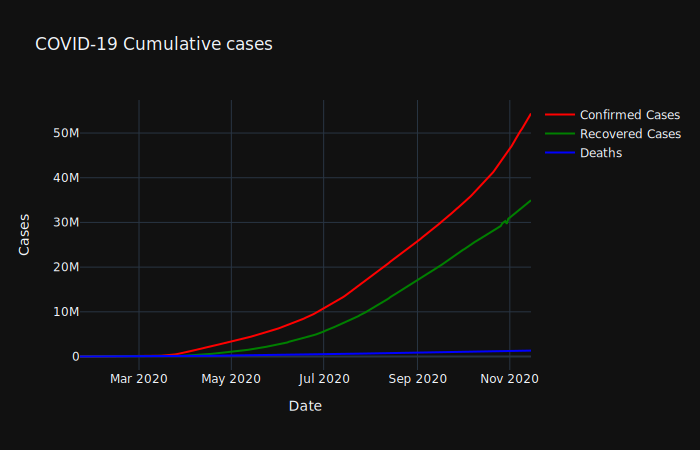

In [17]:
#Plotting a graph for all the 3 categories

trace_Confirmed = go.Scatter(x=cumulative_final.Date,
                  y=cumulative_final.Confirmed,
                  name='Confirmed Cases',
                  marker=dict(color='red'))

trace_Recovered = go.Scatter(x=cumulative_final.Date,
                y=cumulative_final.Recovered,
                name='Recovered Cases',
                marker=dict(color='green'))

trace_Deaths = go.Scatter(x=cumulative_final.Date,
                y=cumulative_final.Deaths,
                name='Deaths',
                marker=dict(color='blue'))

data = [trace_Confirmed, trace_Recovered, trace_Deaths]

layout = go.Layout(title="COVID-19 Cumulative cases",
                xaxis=dict(title='Date'),
                yaxis=dict(title='Cases'))

fig = go.Figure(data=data, layout=layout)
fig.update_layout(template='plotly_dark')
fig.show(renderer="svg")

In [18]:
#Sum of all the cases in the respective categories per day

per_day_cases=cumulative_final.copy()
for i in range(298,0,-1):
    per_day_cases['Deaths'].iloc[i] = per_day_cases['Deaths'].iloc[i]-per_day_cases['Deaths'].iloc[i-1]
    per_day_cases['Confirmed'].iloc[i] = per_day_cases['Confirmed'].iloc[i]-per_day_cases['Confirmed'].iloc[i-1]
    per_day_cases['Recovered'].iloc[i] = per_day_cases['Recovered'].iloc[i]-per_day_cases['Recovered'].iloc[i-1]
per_day_cases.head(10)

,Date,Recovered,Confirmed,Deaths
0,2020-01-22,28.0,555.0,17.0
1,2020-01-23,2.0,98.0,1.0
2,2020-01-24,6.0,288.0,8.0
3,2020-01-25,3.0,497.0,16.0
4,2020-01-26,13.0,680.0,14.0
5,2020-01-27,9.0,809.0,26.0
6,2020-01-28,46.0,2651.0,49.0
7,2020-01-29,19.0,587.0,2.0
8,2020-01-30,17.0,2070.0,38.0
9,2020-01-31,79.0,1690.0,42.0


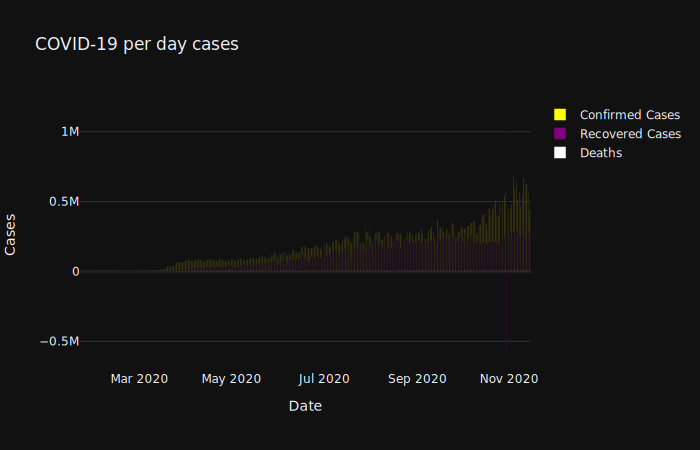

In [19]:
#Plotting a graph for the cases recorded per day

trace_Confirmed = go.Bar(x=per_day_cases.Date,
                  y=per_day_cases.Confirmed,
                  name='Confirmed Cases',
                  marker=dict(color='yellow'))

trace_Recovered = go.Bar(x=per_day_cases.Date,
                y=per_day_cases.Recovered,
                name='Recovered Cases',
                marker=dict(color='purple'))

trace_Deaths = go.Bar(x=per_day_cases.Date,
                y=per_day_cases.Deaths,
                name='Deaths',
                marker=dict(color='white'))

data = [trace_Confirmed, trace_Recovered, trace_Deaths]

layout = go.Layout(title="COVID-19 per day cases",
                xaxis=dict(title='Date'),
                yaxis=dict(title='Cases'))

fig = go.Figure(data=data, layout=layout)
fig.update_layout(template='plotly_dark')

fig.show(renderer="svg")

In [20]:
#Computing the Mortality Rate and Recovery Rate

confirmed['Mortality_rate'] =( confirmed['Deaths']/confirmed['Confirmed']*100) 
confirmed['Recovery_rate'] =( confirmed['Recovered']/confirmed['Confirmed']*100) 
confirmed.head(10)

,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
US,11036935.0,4174884.0,246214.0,2.230819,37.826480
India,8845127.0,8249579.0,130070.0,1.470527,93.266937
Brazil,5863093.0,5279452.0,165798.0,2.827825,90.045510
France,1915713.0,139760.0,42601.0,2.223767,7.295456
Russia,1910149.0,1429565.0,32885.0,1.721593,74.840497
Spain,1458591.0,150376.0,40769.0,2.795095,10.309676
UK,1372884.0,3121.0,52026.0,3.789541,0.227332
Argentina,1310491.0,1129102.0,35436.0,2.704025,86.158699
Colombia,1198746.0,1104956.0,34031.0,2.838883,92.175991


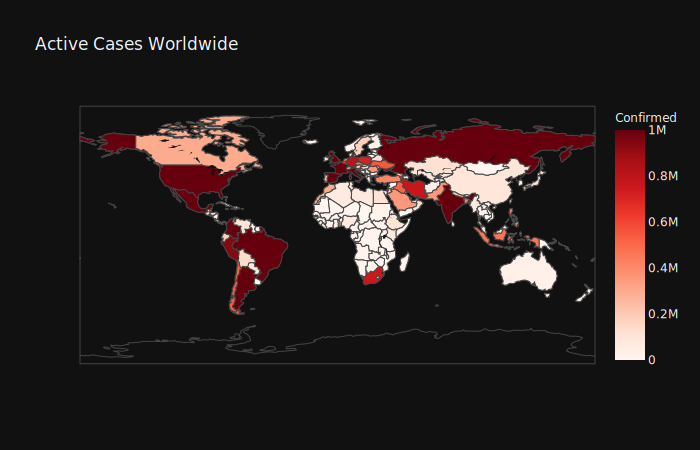

In [21]:
#Chloropleth map with the intensities representing the number of Confirmed Cases

worldplot=confirmed.reset_index()
fig = px.choropleth(worldplot, locations="Country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Country", range_color=[1,1000000], 
                    color_continuous_scale="Reds", 
                    title='Active Cases Worldwide')
fig.update_layout(template='plotly_dark')
fig.show(renderer="svg")

In [22]:
worldplot[["Country","Confirmed","Recovered","Deaths","Mortality_rate","Recovery_rate"]].sort_values(["Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
0,US,11036935.000000,4174884.000000,246214.000000,2.230819,37.826480
1,India,8845127.000000,8249579.000000,130070.000000,1.470527,93.266937
2,Brazil,5863093.000000,5279452.000000,165798.000000,2.827825,90.045510
3,France,1915713.000000,139760.000000,42601.000000,2.223767,7.295456
4,Russia,1910149.000000,1429565.000000,32885.000000,1.721593,74.840497
5,Spain,1458591.000000,150376.000000,40769.000000,2.795095,10.309676
6,UK,1372884.000000,3121.000000,52026.000000,3.789541,0.227332
7,Argentina,1310491.000000,1129102.000000,35436.000000,2.704025,86.158699
8,Colombia,1198746.000000,1104956.000000,34031.000000,2.838883,92.175991
9,Italy,1178529.000000,420810.000000,45229.000000,3.837750,35.706376


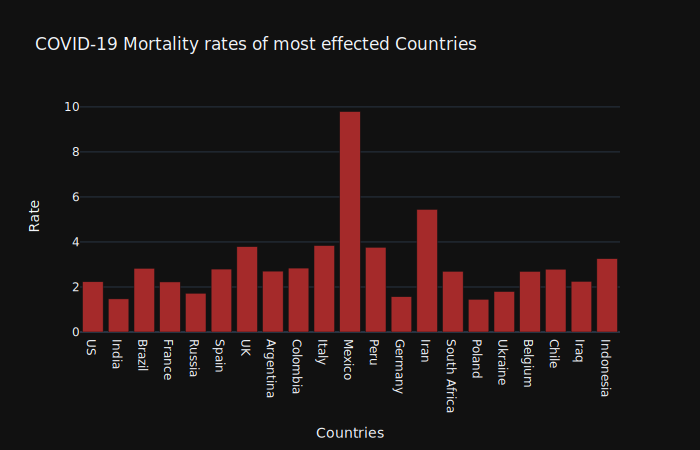

In [23]:
#Bar plot for Mortality vs Recovery rate

countries=confirmed.iloc[0:21]
countries=countries.reset_index()
'''
trace_recovery_rate = go.Bar(x=countries.Country,
                  y=countries.Recovery_rate,
                  name='Recovery Rate',
                  marker=dict(color='indianred'))
'''

trace_mortality_rate = go.Bar(x=countries.Country,
                  y=countries.Mortality_rate,
                  name='Mortality Rate',
                  marker=dict(color='brown')) 


#data = [trace_recovery_rate, trace_mortality_rate]
data = [ trace_mortality_rate]

layout = go.Layout(title="COVID-19 Mortality rates of most effected Countries",
                xaxis=dict(title='Countries'),
                yaxis=dict(title='Rate'))

fig = go.Figure(data=data, layout=layout)
fig.update_layout(template='plotly_dark')

fig.show(renderer="svg")

In [24]:
#Finding the countries with the highest mortality rate

mortality=confirmed.sort_values(by=['Mortality_rate'], ascending=False)
mortality.head()

,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
Yemen,2072.0,1394.0,605.0,29.198842,67.277992
MS Zaandam,9.0,0.0,2.0,22.222222,0.000000
Western Sahara,10.0,8.0,1.0,10.000000,80.000000
Mexico,1006522.0,750190.0,98542.0,9.790347,74.532896
Sudan,14626.0,9571.0,1116.0,7.630248,65.438261


In [25]:
#Finding the countries with highest recovery rate

recovery=confirmed.sort_values(by=['Recovery_rate'], ascending=False)
recovery.head()

,Confirmed,Recovered,Deaths,Mortality_rate,Recovery_rate
Country,,,,,
Marshall Islands,1.0,1.0,0.0,0.000000,100.000000
Saint Kitts and Nevis,19.0,19.0,0.0,0.000000,100.000000
Timor-Leste,30.0,30.0,0.0,0.000000,100.000000
Macau,46.0,46.0,0.0,0.000000,100.000000
Singapore,58119.0,58029.0,28.0,0.048177,99.845145


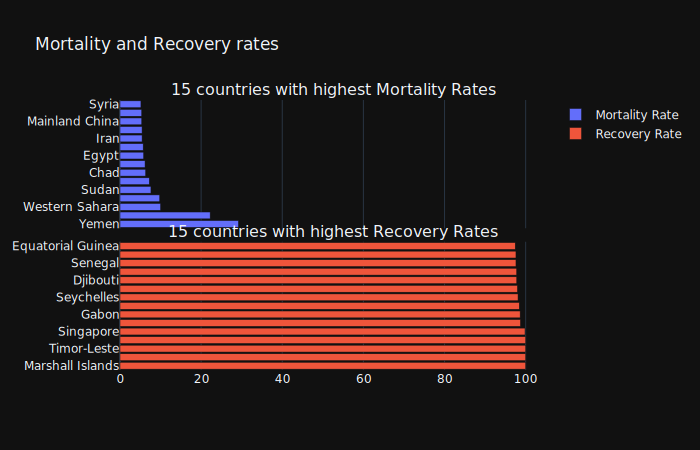

In [26]:
#Plotting the Top 15 countries with highest mortality and recovery rates

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("15 countries with highest Mortality Rates","15 countries with highest Recovery Rates"),
    shared_xaxes=True,
    shared_yaxes=False,
    vertical_spacing=0.05)

top_15_mortality=mortality.sort_values(["Mortality_rate"],ascending=False).head(15)
top_15_recovery=recovery.sort_values(["Recovery_rate"],ascending=False).head(15)

fig.append_trace(go.Bar(
    x=top_15_mortality["Mortality_rate"],
    y=top_15_mortality.index,
    orientation ='h',
    #marker=dict(color='blue'),
    name="Mortality Rate"
), row=1, col=1)

fig.append_trace(go.Bar(
    x=top_15_recovery["Recovery_rate"],
    y=top_15_recovery.index,
    orientation ='h',
    name="Recovery Rate"
), row=2, col=1)
fig.update_layout(height=1000, width=800, title_text="Mortality and Recovery rates")
fig.update_layout(template='plotly_dark')
fig.show(renderer="svg")

In [27]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [28]:
#covid = pd.read_csv("C:/Users/sathi.LAPTOP-6VSGULQ7/Desktop/DA_Project/covid_19_data_latest.csv")
#covid.head()

In [29]:
#A brief overview of the dataset

print("Size/Shape of the dataset: ", covid.shape)
print("Checking for null values:\n", covid.isnull().sum())
print("Checking Data-type of each column:\n", covid.dtypes)

Size/Shape of the dataset:  (156292, 6)
Checking for null values:
 Date             0
State        44313
Country          0
Confirmed        0
Deaths           0
Recovered        0
dtype: int64
Checking Data-type of each column:
 Date         datetime64[ns]
State                object
Country              object
Confirmed           float64
Deaths              float64
Recovered           float64
dtype: object


In [30]:
cumulative_confirmed.set_index('Date',inplace=True)

In [31]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(cumulative_confirmed)

(0.99, True)

In [32]:
#Converting "Observation Date" into pandas Datetime format

covid = covid.rename(columns={'Date':'ObservationDate'})
covid = covid.rename(columns={'Country':'Country/Region'})
covid["ObservationDate"] = pd.to_datetime(covid["ObservationDate"])

In [33]:
#Grouping the data by order of Country/Region and then Observation data

country_wise = covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum', "Recovered":'sum', "Deaths":'sum'})

In [34]:
country_wise

Confirmed  Recovered  Deaths
Country/Region                 ObservationDate                              
 Azerbaijan                    2020-02-28         1.00000    0.00000 0.00000
('St. Martin',)                2020-03-10         2.00000    0.00000 0.00000
Afghanistan                    2020-02-24         1.00000    0.00000 0.00000
                               2020-02-25         1.00000    0.00000 0.00000
                               2020-02-26         1.00000    0.00000 0.00000
...                                                   ...        ...     ...
occupied Palestinian territory 2020-03-12         0.00000    0.00000 0.00000
                               2020-03-14         0.00000    0.00000 0.00000
                               2020-03-15         0.00000    0.00000 0.00000
                               2020-03-16         0.00000    0.00000 0.00000
                               2020-03-17         0.00000    0.00000 0.00000

[48961 rows x 3 columns]

In [35]:
#Calculating the active cases 

country_wise["Active Cases"] = country_wise["Confirmed"] - country_wise["Recovered"] - country_wise["Deaths"]
country_wise["log_confirmed"] = np.log(country_wise["Confirmed"])
country_wise["log_active"] = np.log(country_wise["Active Cases"])

### Datewise analysis

In [36]:
#Grouping different types of cases as per the date

date_wise = covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum', "Recovered":'sum', "Deaths":'sum'})
date_wise["Days Since"] = date_wise.index - date_wise.index.min()

In [37]:
date_wise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.00000,28.00000,17.00000,0 days
2020-01-23,653.00000,30.00000,18.00000,1 days
2020-01-24,941.00000,36.00000,26.00000,2 days
2020-01-25,1438.00000,39.00000,42.00000,3 days
2020-01-26,2118.00000,52.00000,56.00000,4 days


### Brief overview on the Covid statistics

In [38]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ", len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ", date_wise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ", date_wise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ", date_wise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ", (date_wise["Confirmed"].iloc[-1] - date_wise["Recovered"].iloc[-1] - date_wise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ", date_wise["Recovered"].iloc[-1] + date_wise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ", np.round(date_wise["Confirmed"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ", np.round(date_wise["Recovered"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ", np.round(date_wise["Deaths"].iloc[-1]/ date_wise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ", np.round(date_wise["Confirmed"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ", np.round(date_wise["Recovered"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ", np.round(date_wise["Deaths"].iloc[-1]/ ((date_wise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ", date_wise["Confirmed"].iloc[-1] - date_wise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ", date_wise["Recovered"].iloc[-1] - date_wise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ", date_wise["Deaths"].iloc[-1] - date_wise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  226
Total number of Confirmed Cases around the World:  54370186.0
Total number of Recovered Cases around the World:  34955148.0
Total number of Deaths Cases around the World:  1317139.0
Total number of Active Cases around the World:  18097899.0
Total number of Closed Cases around the World:  36272287.0
Approximate number of Confirmed Cases per Day around the World:  181840.0
Approximate number of Recovered Cases per Day around the World:  116907.0
Approximate number of Death Cases per Day around the World:  4405.0
Approximate number of Confirmed Cases per hour around the World:  7577.0
Approximate number of Recovered Cases per hour around the World:  4871.0
Approximate number of Death Cases per hour around the World:  184.0
Number of Confirmed Cases in last 24 hours:  443028.0
Number of Recovered Cases in last 24 hours:  228730.0
Number of Death Cases in last 24 hours:  5947.0


## Time Series Forecasting :

### Holt's Linear Model for confirmed cases

In [39]:
#95% for test data and 5% for training data

model_train = date_wise.iloc[:int(date_wise.shape[0] * 0.95)] 
model_test = date_wise.iloc[int(date_wise.shape[0] * 0.95):]
y_pred = model_test.copy()
train_data = model_train.copy()

In [40]:
#Obtaining the holt linear predictions object using the training data

holt = Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)     

In [41]:
#Obtaining the predictions of the holt linear model using test data

model_scores = []
y_pred["Holt"] = holt.forecast(len(model_test))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  299443.1366178012


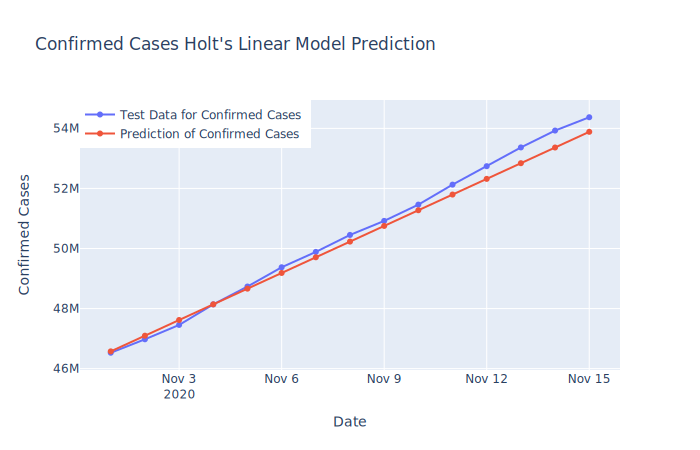

In [42]:
#Model's performance on test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["Holt"],
                    mode = 'lines + markers', name = "Prediction of Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [43]:
#Creating a dataframe to compare the predictions of all the models

holt_new_date=[]
holt_new_prediction = []
for i in range(1,18):
    holt_new_date.append(date_wise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(model_test) + i))[-1])

model_predictions = pd.DataFrame(zip(holt_new_date),
                               columns = ["Dates"])

In [44]:
model_predictions["Holt's Linear Model Prediction"] = holt_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Prediction
0,2020-11-16,54407104.22421
1,2020-11-17,54929270.75833
2,2020-11-18,55451437.29245
3,2020-11-19,55973603.82658
4,2020-11-20,56495770.36070


### Holt's Winter Model for Daily Time Series

In [45]:
#Performing exponential smoothing

es = ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods = 14, trend = 'add', seasonal = 'mul').fit()

In [46]:
#Root mean squared error for Holt's Winter Model

y_pred["Holt's Winter Model"] = es.forecast(len(model_test))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  1061030.4718770147


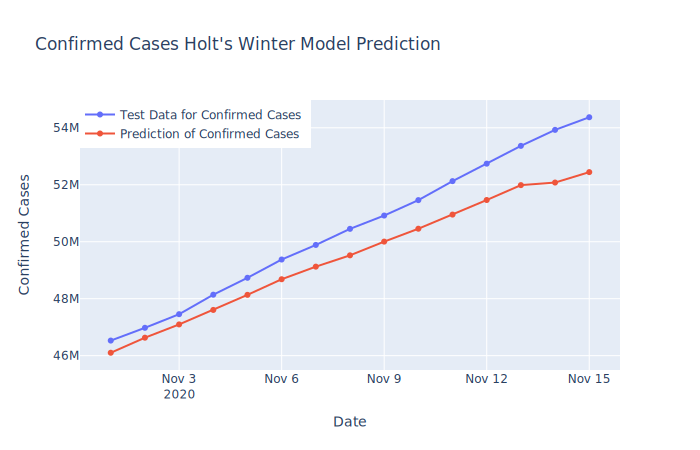

In [47]:
#Obtaining the predictions of the holt winter model using test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["Holt\'s Winter Model"],
                    mode = 'lines + markers', name = "Prediction of Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [48]:
holt_winter_new_prediction = []
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(model_test) + i))[-1])
model_predictions["Holt's Winter Model Prediction"] = holt_winter_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2020-11-16,54407104.22421,52982825.39131
1,2020-11-17,54929270.75833,53450502.49826
2,2020-11-18,55451437.29245,53966124.46209
3,2020-11-19,55973603.82658,54506153.78339
4,2020-11-20,56495770.36070,55066108.15039


### AR Model (using AUTO ARIMA)

In [49]:
#Training the AR model

model_ar = auto_arima(model_train["Confirmed"], trace = True, error_action = 'ignore', start_p = 0, start_q = 0, max_p = 4, max_q = 0,
                   suppress_warnings = True,stepwise = False, seasonal = False)
model_ar.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=6551.178, Time=0.07 sec
Total fit time: 0.280 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [50]:
#Obtaining predictions using AR

prediction_ar = model_ar.predict(len(model_test))
y_pred["AR Model Prediction"] = prediction_ar

In [51]:
#RMSE for AR model

model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  275830.0626998755


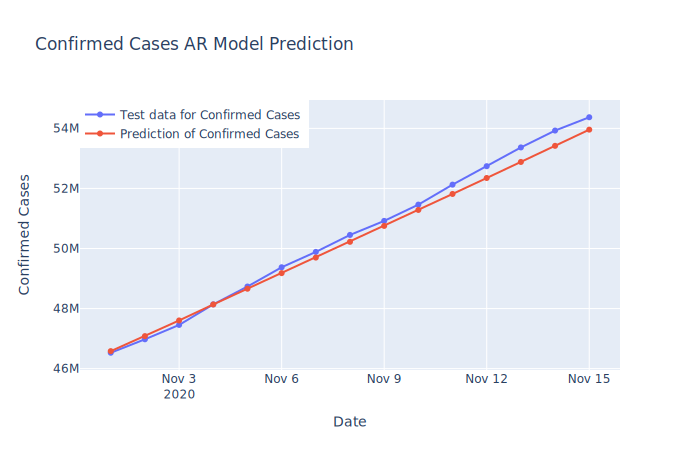

In [52]:
#Making the AR model predictions using test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["AR Model Prediction"],
                    mode = 'lines + markers', name = "Prediction of Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases AR Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [53]:
AR_model_new_prediction = []
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(model_test) + i)[-1])
model_predictions["AR Model Prediction"] = AR_model_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2020-11-16,54407104.22421,52982825.39131,54498625.81997
1,2020-11-17,54929270.75833,53450502.49826,55040887.68493
2,2020-11-18,55451437.29245,53966124.46209,55584723.05109
3,2020-11-19,55973603.82658,54506153.78339,56130497.90252
4,2020-11-20,56495770.36070,55066108.15039,56678345.00233


### MA Model (using AUTO ARIMA)

In [54]:
#Training the MA model

model_ma = auto_arima(model_train["Confirmed"], trace = True, error_action = 'ignore', start_p = 0, start_q = 0, max_p = 0, max_q = 2,
                   suppress_warnings = True, stepwise = False, seasonal = False)
model_ma.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.07 sec
Total fit time: 0.154 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [55]:
#Obtaining predictions using MA model

prediction_ma = model_ma.predict(len(model_test))
y_pred["MA Model Prediction"] = prediction_ma

In [56]:
#RMSE for MA model

model_scores.append(np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_ma)))
print("Root Mean Square Error for MA Model: ", np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_ma)))

Root Mean Square Error for MA Model:  205750.1475257521


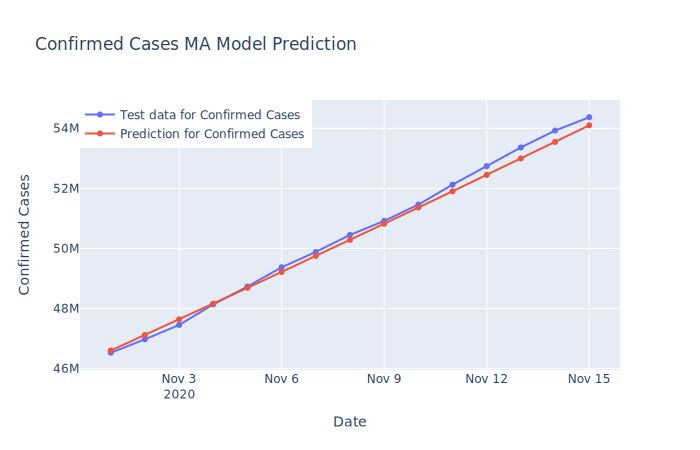

In [57]:
#Checking performance of MA model on the test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["MA Model Prediction"],
                    mode = 'lines + markers', name = "Prediction for Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases MA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [58]:
MA_model_new_prediction = []
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(model_test) + i)[-1])
model_predictions["MA Model Prediction"] = MA_model_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2020-11-16,54407104.22421,52982825.39131,54498625.81997,54657721.98973
1,2020-11-17,54929270.75833,53450502.49826,55040887.68493,55216316.54398
2,2020-11-18,55451437.29245,53966124.46209,55584723.05109,55777608.87674
3,2020-11-19,55973603.82658,54506153.78339,56130497.90252,56341598.98801
4,2020-11-20,56495770.36070,55066108.15039,56678345.00233,56908286.87781


### ARIMA Model (using AUTOARIMA)

In [59]:
#Training the ARIMA model

model_arima = auto_arima(model_train["Confirmed"], trace = True, error_action='ignore', start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                   suppress_warnings = True, stepwise = False, seasonal = False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6609.274, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6564.871, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6583.289, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=6598.046, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6589.274, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6561.739, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=6573.561, Time=0.42 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=6682.732, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6587.251, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=6559.129, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=6613.566, Time=0.54 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=6549.031, Time=0.58 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6568.661, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=6530.336, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=6606.357, Time=0.18 sec
Total fit 

ARIMA(order=(3, 2, 1), scoring_args={}, suppress_warnings=True)

In [60]:
#Obtaining the predictions for the ARIMA model

prediction_arima = model_arima.predict(len(model_test))
y_pred["ARIMA Model Prediction"] = prediction_arima

In [61]:
#RMSE for ARIMA 

model_scores.append(np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ", np.sqrt(mean_squared_error(model_test["Confirmed"], prediction_arima)))

Root Mean Square Error for ARIMA Model:  291923.7983212237


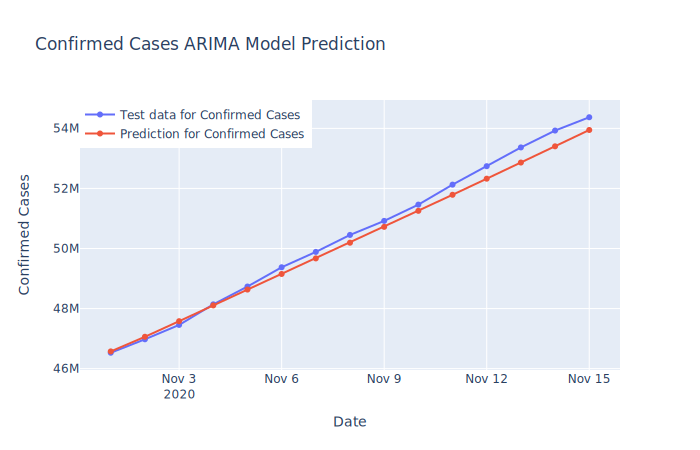

In [62]:
#Checking performance of ARIMA on the test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines + markers', name = "Test data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["ARIMA Model Prediction"],
                    mode = 'lines + markers', name = "Prediction for Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases ARIMA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases",legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [63]:
ARIMA_model_new_prediction = []
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(model_test) + i)[-1])
model_predictions["ARIMA Model Prediction"] = ARIMA_model_new_prediction
model_predictions.head()

,Dates,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2020-11-16,54407104.22421,52982825.39131,54498625.81997,54657721.98973,54492427.45518
1,2020-11-17,54929270.75833,53450502.49826,55040887.68493,55216316.54398,55041294.94069
2,2020-11-18,55451437.29245,53966124.46209,55584723.05109,55777608.87674,55592427.23633
3,2020-11-19,55973603.82658,54506153.78339,56130497.90252,56341598.98801,56145970.09806
4,2020-11-20,56495770.36070,55066108.15039,56678345.00233,56908286.87781,56702104.09791


### SARIMA Model (using AUTO ARIMA)

In [64]:
#Training the SARIMA model

model_sarima = auto_arima(model_train["Confirmed"], trace = True, error_action = 'ignore', 
                         start_p = 0, start_q = 0, max_p = 2, max_q = 2, m = 7,
                   suppress_warnings = True, stepwise = True, seasonal = True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=6522.508, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=6608.241, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=6499.469, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=6511.891, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=6589.078, Time=0.02 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=6471.770, Time=0.29 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=6408.749, Time=0.98 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=6462.800, Time=0.15 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=6464.900, Time=0.44 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=6462.928, Time=0.36 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=6520.747, Time=0.19 sec
 ARIMA(2,2,0)(2,0,1)[7]             : AIC=6449.923, Time=0.40 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=6436.874, Time=0.41 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=6442.011, Time=0.28 sec
 ARIMA(2,2,1)(2,0,1)[7]          

ARIMA(order=(1, 2, 0), scoring_args={}, seasonal_order=(2, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [65]:
#Obtaining the predictions for SARIMA model

prediction_sarima = model_sarima.predict(len(model_test))
y_pred["SARIMA Model Prediction"] = prediction_sarima

In [66]:
#RMSE for SARIMA model

model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ", np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  131681.5882369259


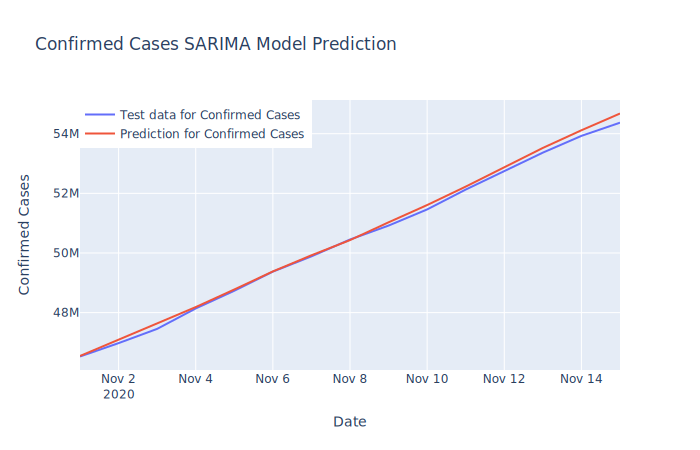

In [67]:
#Checking the performance of SARIMA on the test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Confirmed"],
                    mode = 'lines', name = "Test data for Confirmed Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["SARIMA Model Prediction"],
                    mode = 'lines', name = "Prediction for Confirmed Cases",))
fig.update_layout(title = "Confirmed Cases SARIMA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Confirmed Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [68]:
SARIMA_model_new_prediction = []
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(model_test) + i)[-1])
model_predictions["SARIMA Model Prediction"] = SARIMA_model_new_prediction
model_predictions.tail()

,Dates,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
12,2020-11-28,60673102.63367,58430253.38366,61126858.33162,61538910.02273,61243646.76480,63542400.47641
13,2020-11-29,61195269.16779,58785714.26965,61691130.36466,62129877.91917,61822778.87250,64204981.00200
14,2020-11-30,61717435.70191,59335198.47150,62257231.30069,62723543.59412,62404445.05560,64948332.25272
15,2020-12-01,62239602.23603,59804532.26738,62825175.64964,63319907.04759,62988649.27313,65675339.04885
16,2020-12-02,62761768.77015,60327434.56971,63394961.19530,63918968.27957,63575397.34648,66437939.73885


### Performance of each model by root mean squared error

In [69]:
model_names = ["Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model"]
model_summary = pd.DataFrame(zip(model_names, model_scores), columns = ["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
5,SARIMA Model,131681.58824
3,Moving Average Model (MA),205750.14753
2,Auto Regressive Model (AR),275830.06270
4,ARIMA Model,291923.79832
0,Holt's Linear,299443.13662
1,Holt's Winter Model,1061030.47188


#### SARIMA is the best model for this dataset as it gives us the lowest RMSE value.

### Time Series Forecasting for Death Cases

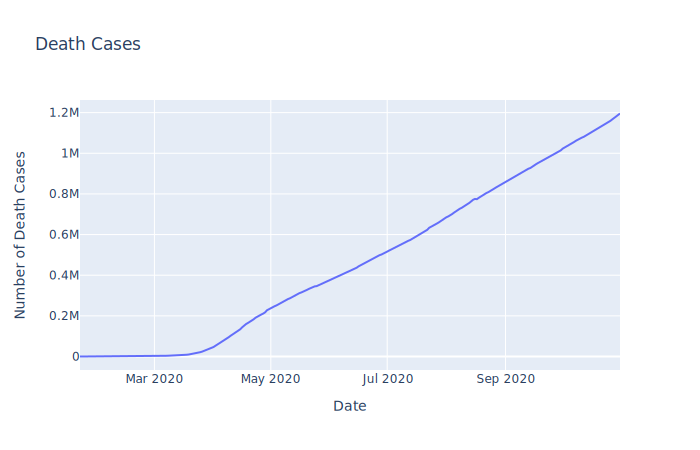

In [70]:
#Visualisation of deaths (Training data)

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_train.index, y = model_train["Deaths"],
                    mode = 'lines', name = "Death Cases"))
fig.update_layout(title = "Death Cases",
                 xaxis_title = "Date", yaxis_title = "Number of Death Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [71]:
#Training the ARIMA model to predict number of deaths

model_arima_deaths = auto_arima(model_train["Deaths"], trace = True, error_action = 'ignore', start_p = 0, start_q = 0,
                              max_p = 5, max_q = 5, suppress_warnings = True, stepwise = False, seasonal = False)     
model_arima_deaths.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4886.909, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4837.034, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4816.258, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=4808.829, Time=0.49 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=4773.153, Time=0.50 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=4768.932, Time=0.60 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4871.080, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4815.559, Time=0.33 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4816.107, Time=0.34 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=4802.277, Time=0.36 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=4766.066, Time=0.69 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4870.660, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4813.497, Time=0.32 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=4820.722, Time=0.65 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=4733.023, Time=0.71 sec
 ARIMA(3,2

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [72]:
#Forming the predictions for ARIMA

predictions_deaths_arima = model_arima_deaths.predict(len(model_test))
y_pred["ARIMA Death Prediction"] = predictions_deaths_arima

In [73]:
#RMSE for ARIMA

model_death_scores = []
model_death_scores.append(np.sqrt(mean_squared_error(y_pred["Deaths"], y_pred["ARIMA Death Prediction"])))
print("Root Mean Square Error for deaths (ARIMA): ", np.sqrt(mean_squared_error(model_test["Deaths"], predictions_deaths_arima)))

Root Mean Square Error for deaths (ARIMA):  7411.744537307475


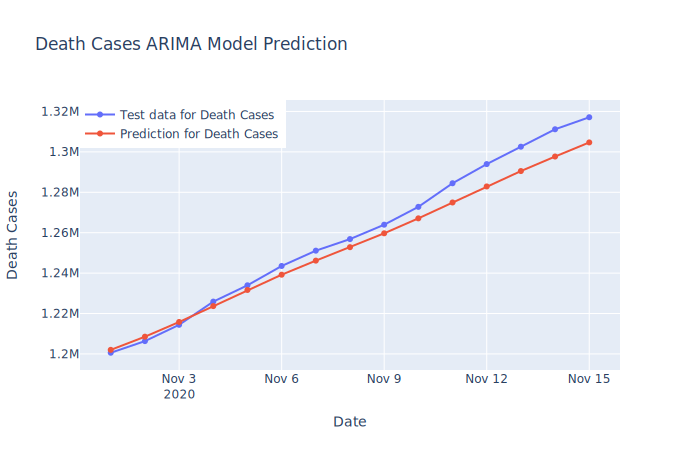

In [74]:
#Checking the performance on test dataset

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Deaths"],
                    mode = 'lines + markers', name = "Test data for Death Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["ARIMA Death Prediction"],
                    mode = 'lines + markers', name = "Prediction for Death Cases",))
fig.update_layout(title = "Death Cases ARIMA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Death Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [75]:
#Training the SARIMA model

model_sarima_deaths = auto_arima(model_train["Deaths"], trace = True, error_action = 'ignore', 
                         start_p = 0, start_q = 0, max_p = 2, max_q = 2, m = 7,
                   suppress_warnings = True, stepwise = True, seasonal = True)
model_sarima_deaths.fit(model_train["Deaths"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4825.002, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4884.994, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4814.716, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4794.789, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=4836.811, Time=0.09 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=4711.704, Time=0.44 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=4754.920, Time=0.28 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=4718.949, Time=1.02 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=4713.038, Time=1.06 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=4740.018, Time=0.49 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=4724.652, Time=0.43 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=1.47 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=4713.704, Time=0.66 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=4713.704, Time=0.72 sec
 ARIMA(1,2,0)(1,0,1)[7]             : 

ARIMA(order=(1, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [76]:
#Forming the predictions using SARIMA model obtained

predictions_deaths_sarima = model_sarima_deaths.predict(len(model_test))
y_pred["SARIMA Death Prediction"] = predictions_deaths_sarima

In [77]:
#RMSE for SARIMA

print("Root Mean Square Error: ", np.sqrt(mean_squared_error(model_test["Deaths"], predictions_deaths_sarima)))

Root Mean Square Error:  7057.699816055571


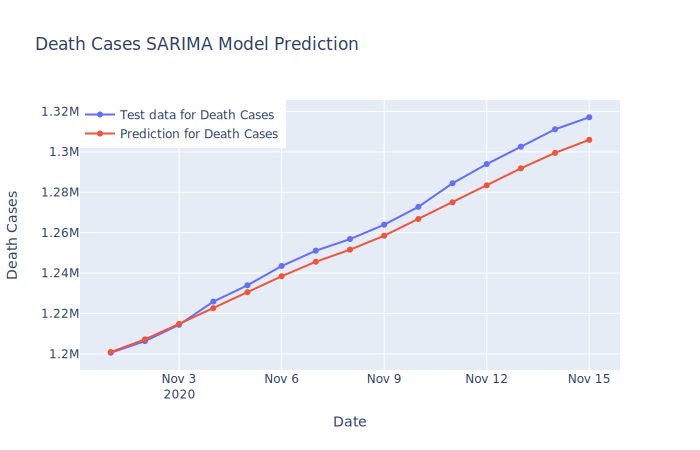

In [78]:
#Checking the performance on test data

fig = go.Figure()
fig.add_trace(go.Scatter(x = model_test.index, y = model_test["Deaths"],
                    mode='lines + markers', name = "Test data for Death Cases",))
fig.add_trace(go.Scatter(x = model_test.index, y = y_pred["SARIMA Death Prediction"],
                    mode = 'lines + markers', name = "Prediction for Death Cases",))
fig.update_layout(title = "Death Cases SARIMA Model Prediction",
                 xaxis_title = "Date", yaxis_title = "Death Cases", legend = dict(x = 0, y = 1, traceorder = "normal"))
fig.show(renderer="svg")

In [79]:
death_forecast_arima = []
death_forecast_sarima = []
for i in range(1,18):
    death_forecast_arima.append(model_arima_deaths.predict(len(model_test) + i)[-1])
for i in range(1,18):
    death_forecast_sarima.append(model_sarima_deaths.predict(len(model_test) + i)[-1])


model_death_predictions = pd.DataFrame(zip(holt_new_date), columns = ["Dates"])
model_death_predictions["ARIMA Model Prediction"] = death_forecast_arima
model_death_predictions["SARIMA Model Prediction"] = death_forecast_sarima

In [80]:
model_death_predictions.head()

,Dates,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-11-16,1311811.63687,1313338.18781
1,2020-11-17,1319346.19086,1321994.20427
2,2020-11-18,1327225.13364,1330657.68525
3,2020-11-19,1335163.96459,1339434.90554
4,2020-11-20,1342873.02179,1348216.70389


### Performance of the models by RMSE

In [81]:
model_death_scores = []
model_death_scores.append(np.sqrt(mean_squared_error(model_test["Deaths"], predictions_deaths_arima)))
model_death_scores.append(np.sqrt(mean_squared_error(model_test["Deaths"], predictions_deaths_sarima)))
model_names = ["ARIMA model death predictions","SARIMA model death predictions"]

In [82]:
death_summary = pd.DataFrame(zip(model_names, model_death_scores), columns = ["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
death_summary

,Model Name,Root Mean Squared Error
1,SARIMA model death predictions,7057.69982
0,ARIMA model death predictions,7411.74454


#### SARIMA is a better model to predict deaths.

#### The model can give a fair idea about the rate at which the virus is going to spread around the globe. This information can be very helpful to understand how and when offices, colleges and other institutions can be opened. To make this model perform better many other factors such as lockdown implementation, control on gatherings, economy etc. need to be considered to predict the inflection points. This is because the number of cases can have an impact if people do not follow the safety norms.